In [13]:
import os
# Load the machine
os.chdir("D:\Python 3.6\pyleecan-master_nik")
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

In [14]:
from pyleecan.Classes.MachineUD import MachineUD
from pyleecan.Classes.MachineIPMSM import MachineIPMSM
from pyleecan.Classes.LamSlotWind import LamSlotWind
from pyleecan.Classes.LamSlot import LamSlot
from pyleecan.Classes.LamHole import LamHole
from pyleecan.Classes.WindingDW2L import WindingDW2L
from pyleecan.Classes.CondType11 import CondType11
from pyleecan.Classes.SlotW11 import SlotW11
from pyleecan.Classes.SlotW22 import SlotW22
from pyleecan.Classes.HoleM57 import HoleM57
from pyleecan.Classes.Shaft import Shaft
from pyleecan.Classes.Frame import Frame
from pyleecan.Classes.VentilationCirc import VentilationCirc
from pyleecan.Classes.Material import Material
from pyleecan.Classes.MatMagnetics import MatMagnetics
from numpy import pi,tan,array

In [15]:
#__INPUT PARAMETERS__

mm=1

slot_lam_dia=124.1*mm
stator_bore=83.6*mm
slot_number=24
tooth_tip_depth=0.66*mm
slot_depth=16.5*mm                          #modified(1)
slot_opening=2.4*mm
slot_corner_radius=(0.67-0.158)*mm           #modified(2)
tooth_tip_angle=(28/180)*pi
tooth_width=5*mm
shaft_dia=25*mm
airgap=0.5*mm
L1_rduct_rad_dia=62*mm
L1_rduct_dia=6.2*mm         #to be verified                  
magnet_thickness=5*mm
mag_width=20*mm
bridge_thickness=0.8*mm-0.4*mm      #modified(3)
pole_number=10


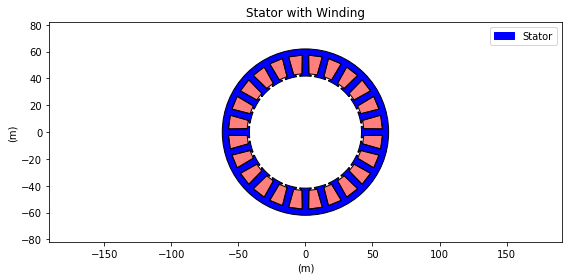

In [16]:
#___DEFINING THE STATOR AND SLOTS___

machine=MachineUD()

Rext=slot_lam_dia/2
Rint=stator_bore/2
w2=((2*pi*(Rint+slot_depth-slot_corner_radius)-slot_number*tooth_width)/slot_number)      #better if explicitly known, derived it(with a few approximations) based on given known parameters
w1=(slot_opening+w2)/2                                                                    #estimated w1 to be the average of w2 and slot opening as it was not explicitly given


stator = LamSlotWind(Rext=Rext, Rint=Rint, is_internal=False, is_stator=True)
stator.slot = SlotW11(
    Zs=slot_number,
    H0=tooth_tip_depth,  
    H1=tooth_tip_angle, 
    H1_is_rad= True,
    W0=slot_opening, 
    W1=w1,
    W2=w2,
    R1=slot_corner_radius ,
    H2=slot_depth-tooth_tip_depth-(w1-slot_opening)*tan(tooth_tip_angle)                  #better if explicitly known, derived it(with a few approximations) based on given known parameters
)

stator.plot()

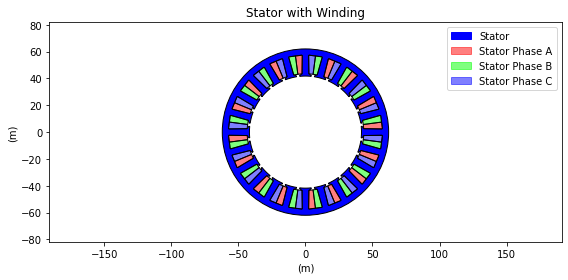

In [17]:
from pyleecan.Classes.WindingDW1L import WindingDW1L
stator.winding = WindingDW2L(
    qs=3,  # number of phases
    Lewout=1,  # staight length of conductor outside lamination before EW-bend                    #not sure what this means
    p=4,  # number of pole pairs
    Ntcoil=2,  # number of turns per coil                      #to be verified
    Npcpp=1,  # number of parallel circuits per phase          #to be verified
    coil_pitch =4         #not sure if it is to be mentioned in mm or in terms of number ofslots
)

stator.winding.conductor = CondType11(
    Nwppc_tan=1, # stator winding number of preformed wires (strands)
                 # in parallel per coil along tangential (horizontal) direction
    Nwppc_rad=1, # stator winding number of preformed wires (strands)
                 # in parallel per coil along radial (vertical) direction
    Wwire=0.000912, #  single wire width without insulation [m]
    Hwire=2e-3, # single wire height without insulation [m]
    Wins_wire=1e-6, # winding strand insulation thickness [m]
    type_winding_shape=0, # type of winding shape for end winding length calculation
                          # 0 for hairpin windings
                          # 1 for normal windings
)

# Dont have these details, so commenting it out for now

# stator.winding.conductor = CondType11(
#     Nwppc_tan=   # stator winding number of preformed wires (strands)
#                  # in parallel per coil along tangential (horizontal) direction
#     Nwppc_rad =  , # stator winding number of preformed wires (strands)
#                  # in parallel per coil along radial (vertical) direction
#     Wwire=  , #  single wire width without insulation [m]
#     Hwire=  , # single wire height without insulation [m]
#     Wins_wire=  , # winding strand insulation thickness [m]
#     type_winding_shape=  , # type of winding shape for end winding length calculation
#                           # 0 for hairpin windings
#                           # 1 for normal windings
# )
stator.plot()

In [18]:
stator.winding.coil_pitch

4

In [19]:
#DEFINING THE ROTOR

rotor = LamHole(
    Rint=(shaft_dia/2) , # Internal radius
    Rext=((stator_bore/2)-airgap), # external radius
    is_internal=True,
    is_stator=False,
)


In [22]:
#ADDING HOLES FOR THE MAGNET AND VENTILATION DUCTS IN THE ROTOR
from pyleecan.Classes.Hole_Rectangular import Hole_Rectangular
rotor.hole = list()

# rotor.hole.append(VentilationCirc(Alpha0=pi/10, D0=L1_rduct_dia/2, H0=L1_rduct_rad_dia/2, Zh=pole_number*2))

rotor.hole.append(
     Hole_Rectangular(H0 = bridge_thickness,    
             H1 = magnet_thickness,
             H2 = 0 * mm,
             W0 = mag_width
             W3 = 1.51 * mm,                  #NOT SPECIFIED BY THEM, HAVE TO ASK
             magnet_0= -1,
             Zh = pole_number
        
            )
)



Magnet = Material(name="N42UH")

#These below properties are to be verified, have found them online for the N42 Magnet 
Magnet.mag = MatMagnetics(
    mur_lin = 1.05, # Relative magnetic permeability                           
    Hc = 943000, # Coercitivity field [A/m]
    alpha_Br = -0.120, # temperature coefficient for remanent flux density /°C compared to 20°C
    Brm20 = 1.315, # magnet remanence induction at 20°C [T]
    Wlam = 0, # lamination sheet width without insulation [m] (0 == not laminated)
)


Magnet.elec.rho = 1.8e-06
Magnet.struct.rho = 7500.0 

#rotor.hole[0].check()
rotor.hole[0].magnet_0.mat_type = Magnet       
rotor.hole[0].magnet_0.type_magnetization = 0            
             
rotor.plot()


ImportError: Can't use Hole_Rectangular method comp_radius: No module named 'pyleecan.Methods.Slot.Hole_Rectangular'

In [ ]:
#SHAFT DEFINTION

shaft = None

In [ ]:
#MATERIALS SPECIFICATION (ONLY SPECIFIED FOR THE STATOR AND ROTOR FOR NOW.......have seen that the housing,endcaps,bearings etc have different materials,not specified for now)



M400_50A = load(join(DATA_DIR, "Material", "M400-50A.json"))
Copper1 = load(join(DATA_DIR, "Material", "Copper1.json"))

Magnet = Material(name="N42UH")



#These below properties are to be verified, have found them online for the N42 Magnet 
Magnet.mag = MatMagnetics(
    mur_lin = 1.05, # Relative magnetic permeability                           
    Hc = 943000, # Coercitivity field [A/m]
    alpha_Br = -0.120, # temperature coefficient for remanent flux density /°C compared to 20°C
    Brm20 = 1.315, # magnet remanence induction at 20°C [T]
    Wlam = 0, # lamination sheet width without insulation [m] (0 == not laminated)
)


Magnet.elec.rho = 1.8e-06
Magnet.struct.rho = 7500.0 

stator.mat_type = M400_50A                   #Though M250-35A is mentioned pylecaan doesnt have that particular grade.Have to see if anything is to be modifed in the json file to meet our requirement
rotor.mat_type = M400_50A
stator.winding.conductor.cond_mat = Copper1

rotor.hole[0].magnet_0.mat_type = Magnet
# rotor.hole[0].magnet_1.mat_type = Magnet
rotor.hole[0].magnet_0.type_magnetization = 1
# rotor.hole[0].magnet_1.type_magnetization = 1                #not sure what this means, defined it similar to the tutorial code

In [ ]:
_5kW_motor = MachineIPMSM(
    name="5kW-Motor",
    stator=stator,
    rotor=rotor,
    shaft=None,
    frame=None
)
_5kW_motor.plot()

In [ ]:
from pyleecan.Classes.MagFEMM import MagFEMM
mag = MagFEMM(
    type_BH_stator=0, # 0 to use the material B(H) curve,
                      # 1 to use linear B(H) curve according to mur_lin,
                      # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=0,  # 0 to use the material B(H) curve,
                      # 1 to use linear B(H) curve according to mur_lin,
                      # 2 to enforce infinite permeability (mur_lin =100000)
    file_name = "5kW-Motor", # Name of the file to save the FEMM model
)


In [ ]:
from pyleecan.Classes._FEMMHandler import FEMMHandler
from pyleecan.Classes.Circle import Circle
from pyleecan.Functions.FEMM.get_airgap_surface import get_airgap_surface

from pyleecan.Functions.FEMM.comp_FEMM_dict import comp_FEMM_dict

kgeo_fineness = 1
kmesh_fineness = 1
type_calc_leakage = 0

FEMM_dict = comp_FEMM_dict(
        _5kW_motor, kgeo_fineness, kmesh_fineness, type_calc_leakage
    )
FEMM_dict.update(_5kW_motor.as_dict())


In [ ]:
surf_list = list()
lam_list = _5kW_motor.get_lam_list()
lam_int = lam_list[0]
lam_ext = lam_list[1]

sym = 1
# Adding no_mesh for shaft if needed
# if lam_int.Rint > 0 and sym == 1:
#     surf_list.append(Circle(point_ref=0, radius=lam_int.Rint, label="No_mesh"))

surf_list.extend(get_airgap_surface(lam_int=lam_int, lam_ext=lam_ext))
surf_list.extend(_5kW_motor.rotor.build_geometry(sym=sym))
surf_list.extend(_5kW_motor.stator.build_geometry(sym=sym))




In [ ]:
femm = FEMMHandler(True)
femm.openfemm(1)  # 1 == open in background, 0 == open normally
femm.newdocument(0)
femm.mi_probdef(0, "millimeters", FEMM_dict["pbtype"], FEMM_dict["precision"])


In [ ]:
# Draw and assign all the surfaces of the machine
from pyleecan.Functions.FEMM.get_mesh_param import get_mesh_param
from pyleecan.Functions.FEMM.assign_FEMM_surface import assign_FEMM_surface
from pyleecan.Functions.FEMM.create_FEMM_materials import create_FEMM_materials
from pyleecan.Functions.FEMM.create_FEMM_boundary_conditions import (
    create_FEMM_boundary_conditions,
)

from pyleecan.Classes.Arc1 import Arc1
from pyleecan.Classes.Arc2 import Arc2
from pyleecan.Classes.Arc3 import Arc3
num_readings=32
# Creation of all the materials and circuit in FEMM
BHs = array(FEMM_dict['stator']['mat_type']['mag']['BH_curve']['value'])  # Stator B(H) curve
BHr = array(FEMM_dict['rotor']['mat_type']['mag']['BH_curve']['value'])
is_mmfs = 0
is_mmfr = 0
Is = array([[8]*num_readings, [0]*num_readings, [0] * num_readings]).transpose()
Ir = Is
type_BH_stator = 0
type_BH_stator = 0
is_eddies = 0

prop_dict, materials, circuits = create_FEMM_materials(
        femm,
        _5kW_motor,
        surf_list,
        Is,
        Ir,
        BHs,
        BHr ,
        is_mmfs,
        is_mmfr,
        type_BH_stator = 0,
        type_BH_rotor = 0,
        is_eddies = 0,
        j_t0=0,
    )
    
create_FEMM_boundary_conditions(femm=femm, sym=sym, is_antiper=0)

nodeprop="None"
maxseg=FEMM_dict["arcspan"]
propname="None"
hide= False
for surf in surf_list:
    label = surf.label
    #print (label)
    surf.check()
    # Draw all the lines
    lines = surf.get_lines()
    for line in lines:
        if line.label in [None, ""]:  # Use surface mesh param
            mesh_dict = get_mesh_param(surf.label, FEMM_dict)
        else:  # Use line mesh param
            mesh_dict = get_mesh_param(line.label, FEMM_dict)
        if type(line) in [Arc1, Arc2, Arc3]:
            line.draw_FEMM(
                femm=femm,
                nodeprop=nodeprop,
                maxseg=maxseg,
                propname=propname,
                hide=hide,
                group=mesh_dict["group"],
            )
        else:
            line.draw_FEMM(
                femm=femm,
                nodeprop=nodeprop,
                propname=propname,
                element_size=mesh_dict["element_size"],
                automesh=mesh_dict["automesh"],
                hide=hide,
                group=mesh_dict["group"],
            )
        #Uncomment below line for materials also.Comment it when you want to compare DXFs.
        assign_FEMM_surface(
            femm, surf, prop_dict[label], FEMM_dict, _5kW_motor.rotor, _5kW_motor.stator
        )
    
